In [1]:
from keras import Input, layers, backend, Model, losses, datasets, models, metrics, optimizers, initializers
from keras.utils import Sequence
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [2]:

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        """Here self.x is a list of paths to .npy input files. self.y is a
        corresponding list of paths to .npy output files."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(np.array([np.load(file_name) for file_name in batch_x]).shape, np.array([np.load(file_name) for file_name in batch_y]).shape)
        return np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_x]), np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_y])
    

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\electron_dists\\Data\\VAE_000_1\\Data"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        input_paths = []
        output_paths = []
        for crystal in os.listdir(segment_path):
            crystal_path = os.path.join(segment_path, crystal)
            files = sorted(os.listdir(crystal_path))
            input_paths.append(os.path.join(crystal_path, files[0]))
            output_paths.append(os.path.join(crystal_path, files[1]))
        yield [input_paths, output_paths]

def gen_paths_fromfile(Path):
    input_paths = []
    output_paths = []
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    #print(lines)
    for i in lines:
        output_paths.append(i[0])
        input_paths.append(i[0].split("Output.npy")[0] + "Input.npy")
    return([input_paths, output_paths])

In [3]:
latent_dim = 10

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [4]:
"""
## Build the encoder
"""
encoder_inputs = Input(shape=(128, 128, 1))
x = layers.Conv2D(32, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
#x = layers.Dropout(0.25)(x) #APPARANTLY THEY ARE BAD
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='zeros', bias_initializer='zeros')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   2080        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   131136      conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 65536)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
"""
## Build the decoder
"""


latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
#x = layers.Dropout(0.25)(x)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(128, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, kernel_size = (2, 2), activation="relu", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             720896    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 128)       524416    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      524352    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       257       
Total params: 1,769,921
Trainable params: 1,769,921
Non-trainable params: 0
_________________________________________________

In [6]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                )
            )
            #print(z_mean, z_log_var, z)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, data):
        return self.decoder(self.encoder(data)[2])

#losses.MSE(y, reconstruction), axis=(1, 2)
#losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)

In [19]:
def ShuffleIndex(size):
    index = np.arange(size)
    np.random.shuffle(index)
    return(index)

def CreatePaths(All_Paths_in, All_Paths_out, Shuffle_Index, Subset_Fraction):
    New_Path_in = []
    New_Path_out = []
    Shuffle_Index = Shuffle_Index[:int(Subset_Fraction * len(All_Paths_in))]
    for i in Shuffle_Index:
        New_Path_in.append(All_Paths_in[i])
        New_Path_out.append(All_Paths_out[i])
    return(New_Path_in, New_Path_out)

In [21]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")

vae = VAE(encoder, decoder)
#vae.add_metric(trainable_metric(vae), name="testMetric")
vae.compile(optimizer=optimizers.Adam())


batch_size=64
#data_path = "/home/ug-ml/felix-ML/VAE_000/Data/FilePaths/"
data_path = "/home/ug-ml/felix-ML/VAE_000/Data/Data/"

data_fraction = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1]
data = [i for i in gen_paths_labels(data_path)]

Track_val_loss = []


val_in, val_out = data[2][0], data[2][1]
train_in, train_out = data[1][0], data[1][1]
test_in, test_out = data[0][0], data[0][1]


val_index = ShuffleIndex(len(val_in))
train_index = ShuffleIndex(len(train_in))
test_index = ShuffleIndex(len(test_in))

for f in data_fraction:
    val_paths_in, val_paths_out = CreatePaths(val_in, val_out, val_index, f)
    train_paths_in, train_paths_out = CreatePaths(train_in, train_out, train_index, f)
    test_paths_in, test_paths_out = CreatePaths(test_in, test_out, test_index, f)
    
    val_seq = FelixSequence(val_paths_in, val_paths_out, batch_size)
    train_seq = FelixSequence(train_paths_in, train_paths_out, batch_size)
    test_seq = FelixSequence(test_paths_in, test_paths_out, batch_size)


    epochs = 1500
    patience = 20


    patience_i = 0
    best_val_loss = np.inf

    #training and validation histories, containing [0] the total loss, [1] the reconstruction loss, and [2] the kl loss.
    val_hist = np.zeros(shape=(1,epochs))
    train_hist = np.zeros(shape=(3,epochs))

    for epoch in range(0, epochs):
        print("-------------------------------------------------------------------------")
        print("Epoch", epoch, "/", epochs, ": ")
        print("Training: ")
        hist = vae.fit(x = train_seq, shuffle=True, epochs = epoch+1, workers = 16, initial_epoch=epoch)
        train_hist[0][epoch] = hist.history["loss"][0]
        train_hist[1][epoch] = hist.history["reconstruction_loss"][0]
        train_hist[2][epoch] = hist.history["kl_loss"][0]
        print("Validation: ")

        tot_batch_recon_loss = 0
        count = 0
        for x, y in val_seq:
            #print(x.shape, y.shape)
            count += 1
            reconstruction = vae(x)
            reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                    losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                    )
                )
            tot_batch_recon_loss += reconstruction_loss
            #print(batch_log_loss)

        avg_recon_loss = float(tot_batch_recon_loss/count)
        if(avg_recon_loss < best_val_loss):
            print("The model improved from: ",best_val_loss, "to: ", avg_recon_loss)
            best_val_loss = avg_recon_loss
            patience_i = 0
        else:
            patience_i+=1
            print("The model did not improve, patience_i = ", patience_i)

        print("Average reconstruction loss: ", avg_recon_loss)
        val_hist[0][epoch] = avg_recon_loss
        if(patience_i > patience):
            print("Early Stopping, the model did not improve from: ", best_val_loss)
            Track_val_loss.append(best_val_loss)
            break

    print("-------------------------------------------------------------------------")
    print("Testing: ")
    loss = vae.evaluate(test_seq)
    print("loss: "+str(loss))
    
    np.save("SaveModel/VAE_data_scaling_train_loss"+str(d)+".npy", train_hist)
    np.save("SaveModel/VAE_data_scaling_val_loss"+str(d)+".npy", val_hist)



-------------------------------------------------------------------------
Epoch 0 / 1500 : 
Training: 
5/5 [==============================] - 1s 182ms/step - loss: 447.2960 - reconstruction_loss: 448.2366 - kl_loss: 5.2483
Validation: 
The model improved from:  inf to:  417.3535461425781
Average reconstruction loss:  417.3535461425781
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
Epoch 2/2
5/5 [==============================] - 1s 106ms/step - loss: 429.7717 - reconstruction_loss: 440.5280 - kl_loss: 4.7811
Validation: 
The model improved from:  417.3535461425781 to:  409.27545166015625
Average reconstruction loss:  409.27545166015625
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 3/3
5/5 [==============================] - 1s 106ms/step - loss: 432.1409 - reconstruction_loss: 429.7668 - kl_loss: 5.1982
Validation: 
The model did not improve, patience_i =  1
Average rec

5/5 [==============================] - 1s 121ms/step - loss: 362.0285 - reconstruction_loss: 359.7562 - kl_loss: 7.8484
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  416.64324951171875
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 25/25
5/5 [==============================] - 1s 112ms/step - loss: 362.4985 - reconstruction_loss: 358.4520 - kl_loss: 8.0115
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  418.75970458984375
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 
Epoch 26/26
5/5 [==============================] - 1s 108ms/step - loss: 355.7298 - reconstruction_loss: 359.9606 - kl_loss: 8.6563
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  412.261962890625
-------------------------------------------------------------------------
Epoch 26 / 1500 : 

10/10 [==============================] - 1s 111ms/step - loss: 333.6906 - reconstruction_loss: 317.6530 - kl_loss: 10.5972
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  372.639404296875
-------------------------------------------------------------------------
Epoch 17 / 1500 : 
Training: 
Epoch 18/18
10/10 [==============================] - 1s 109ms/step - loss: 341.5833 - reconstruction_loss: 316.3322 - kl_loss: 10.9577
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  384.86865234375
-------------------------------------------------------------------------
Epoch 18 / 1500 : 
Training: 
Epoch 19/19
10/10 [==============================] - 1s 110ms/step - loss: 333.3611 - reconstruction_loss: 307.6651 - kl_loss: 11.4214
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  363.90289306640625
-------------------------------------------------------------------------
Epoch 19 / 1500

10/10 [==============================] - 1s 111ms/step - loss: 279.2384 - reconstruction_loss: 263.0660 - kl_loss: 15.1742
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  352.1751708984375
-------------------------------------------------------------------------
Epoch 38 / 1500 : 
Training: 
Epoch 39/39
10/10 [==============================] - 2s 233ms/step - loss: 270.7170 - reconstruction_loss: 265.4738 - kl_loss: 14.6613
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  379.9520263671875
-------------------------------------------------------------------------
Epoch 39 / 1500 : 
Training: 
Epoch 40/40
10/10 [==============================] - 1s 108ms/step - loss: 282.2267 - reconstruction_loss: 266.8914 - kl_loss: 14.9099
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  359.3399658203125
-------------------------------------------------------------------------
Epoch 40 / 15

19/19 [==============================] - 2s 115ms/step - loss: 291.7766 - reconstruction_loss: 268.2468 - kl_loss: 17.1292
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  357.1424865722656
-------------------------------------------------------------------------
Epoch 8 / 1500 : 
Training: 
Epoch 9/9
19/19 [==============================] - 4s 194ms/step - loss: 264.9619 - reconstruction_loss: 260.7968 - kl_loss: 16.7085
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  346.8056335449219
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoch 10/10
19/19 [==============================] - 2s 114ms/step - loss: 281.2027 - reconstruction_loss: 259.6566 - kl_loss: 17.0223
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  352.0332336425781
-------------------------------------------------------------------------
Epoch 10 / 1500 :

19/19 [==============================] - 2s 117ms/step - loss: 222.5389 - reconstruction_loss: 216.3473 - kl_loss: 19.8598
Validation: 
The model improved from:  335.8167419433594 to:  335.2588195800781
Average reconstruction loss:  335.2588195800781
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 31/31
19/19 [==============================] - 2s 115ms/step - loss: 238.0477 - reconstruction_loss: 215.4902 - kl_loss: 20.1321
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  341.7862548828125
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 32/32
19/19 [==============================] - 4s 198ms/step - loss: 217.3272 - reconstruction_loss: 213.8978 - kl_loss: 20.4426
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  339.7787780761719
---------------------------------------------------------------

19/19 [==============================] - 2s 116ms/step - loss: 195.4210 - reconstruction_loss: 178.8980 - kl_loss: 22.8209
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  338.2771911621094
-------------------------------------------------------------------------
Epoch 51 / 1500 : 
Training: 
Epoch 52/52
19/19 [==============================] - 2s 117ms/step - loss: 200.8486 - reconstruction_loss: 176.2069 - kl_loss: 23.0889
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  334.6026611328125
-------------------------------------------------------------------------
Epoch 52 / 1500 : 
Training: 
Epoch 53/53
19/19 [==============================] - 2s 116ms/step - loss: 198.0824 - reconstruction_loss: 175.6432 - kl_loss: 23.0436
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  340.2130432128906
-------------------------------------------------------------------------
Epoch 53 /

28/28 [==============================] - 3s 118ms/step - loss: 204.3987 - reconstruction_loss: 178.8852 - kl_loss: 24.8593
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  288.69683837890625
-------------------------------------------------------------------------
Epoch 12 / 1500 : 
Training: 
Epoch 13/13
28/28 [==============================] - 4s 159ms/step - loss: 193.8540 - reconstruction_loss: 177.1478 - kl_loss: 24.7865
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  285.45623779296875
-------------------------------------------------------------------------
Epoch 13 / 1500 : 
Training: 
Epoch 14/14
28/28 [==============================] - 3s 118ms/step - loss: 204.8617 - reconstruction_loss: 179.8439 - kl_loss: 24.7083
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  282.696044921875
-------------------------------------------------------------------------
Epoch 14 / 

28/28 [==============================] - 3s 118ms/step - loss: 170.9573 - reconstruction_loss: 145.4061 - kl_loss: 25.7459
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  274.0326843261719
-------------------------------------------------------------------------
Epoch 33 / 1500 : 
Training: 
Epoch 34/34
28/28 [==============================] - 3s 117ms/step - loss: 163.5452 - reconstruction_loss: 140.7631 - kl_loss: 25.7420
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  273.9565124511719
-------------------------------------------------------------------------
Epoch 34 / 1500 : 
Training: 
Epoch 35/35
28/28 [==============================] - 3s 118ms/step - loss: 164.0559 - reconstruction_loss: 141.6704 - kl_loss: 25.7542
Validation: 
The model improved from:  269.74542236328125 to:  268.6567077636719
Average reconstruction loss:  268.6567077636719
--------------------------------------------------------------

28/28 [==============================] - 3s 117ms/step - loss: 149.4563 - reconstruction_loss: 119.4960 - kl_loss: 26.8109
Validation: 
The model improved from:  265.2697448730469 to:  264.30328369140625
Average reconstruction loss:  264.30328369140625
-------------------------------------------------------------------------
Epoch 54 / 1500 : 
Training: 
Epoch 55/55
28/28 [==============================] - 3s 119ms/step - loss: 143.3550 - reconstruction_loss: 117.5885 - kl_loss: 26.7271
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  269.6341552734375
-------------------------------------------------------------------------
Epoch 55 / 1500 : 
Training: 
Epoch 56/56
28/28 [==============================] - 3s 118ms/step - loss: 142.1314 - reconstruction_loss: 116.2572 - kl_loss: 26.7758
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  277.7004699707031
-------------------------------------------------------------

28/28 [==============================] - 3s 119ms/step - loss: 128.5744 - reconstruction_loss: 99.1551 - kl_loss: 27.2496
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  262.95379638671875
-------------------------------------------------------------------------
Epoch 78 / 1500 : 
Training: 
Epoch 79/79
28/28 [==============================] - 3s 118ms/step - loss: 128.7225 - reconstruction_loss: 99.0311 - kl_loss: 27.1183
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  263.08123779296875
-------------------------------------------------------------------------
Epoch 79 / 1500 : 
Training: 
Epoch 80/80
28/28 [==============================] - 3s 118ms/step - loss: 129.7640 - reconstruction_loss: 99.3278 - kl_loss: 27.2822
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  266.2237548828125
-------------------------------------------------------------------------
Epoch 80 / 150

28/28 [==============================] - 3s 118ms/step - loss: 117.0572 - reconstruction_loss: 89.8939 - kl_loss: 27.3429
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  257.4755859375
-------------------------------------------------------------------------
Epoch 100 / 1500 : 
Training: 
Epoch 101/101
28/28 [==============================] - 3s 118ms/step - loss: 114.1270 - reconstruction_loss: 90.8846 - kl_loss: 27.2613
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  265.03778076171875
-------------------------------------------------------------------------
Epoch 101 / 1500 : 
Training: 
Epoch 102/102
28/28 [==============================] - 3s 119ms/step - loss: 115.9860 - reconstruction_loss: 88.9714 - kl_loss: 27.2963
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  265.7001953125
-------------------------------------------------------------------------
Epoch 102 / 

46/46 [==============================] - 6s 120ms/step - loss: 152.7792 - reconstruction_loss: 125.1727 - kl_loss: 26.9415
Validation: 
The model improved from:  255.1908721923828 to:  255.17784118652344
Average reconstruction loss:  255.17784118652344
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoch 10/10
46/46 [==============================] - 6s 131ms/step - loss: 154.0877 - reconstruction_loss: 122.2505 - kl_loss: 26.8031
Validation: 
The model improved from:  255.17784118652344 to:  254.46278381347656
Average reconstruction loss:  254.46278381347656
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 11/11
46/46 [==============================] - 6s 120ms/step - loss: 143.8369 - reconstruction_loss: 121.3297 - kl_loss: 26.9210
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  257.060791015625
------------------------------------

46/46 [==============================] - 6s 120ms/step - loss: 126.5435 - reconstruction_loss: 101.4613 - kl_loss: 27.5323
Validation: 
The model improved from:  249.8463897705078 to:  249.4763641357422
Average reconstruction loss:  249.4763641357422
-------------------------------------------------------------------------
Epoch 32 / 1500 : 
Training: 
Epoch 33/33
46/46 [==============================] - 6s 120ms/step - loss: 122.6987 - reconstruction_loss: 97.4612 - kl_loss: 27.3829
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  254.740478515625
-------------------------------------------------------------------------
Epoch 33 / 1500 : 
Training: 
Epoch 34/34
46/46 [==============================] - 6s 121ms/step - loss: 120.8761 - reconstruction_loss: 97.7383 - kl_loss: 27.5158
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  256.8128662109375
------------------------------------------------------------------

46/46 [==============================] - 6s 121ms/step - loss: 110.0167 - reconstruction_loss: 87.6542 - kl_loss: 27.5330
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  251.69288635253906
-------------------------------------------------------------------------
Epoch 55 / 1500 : 
Training: 
Epoch 56/56
46/46 [==============================] - 6s 120ms/step - loss: 118.8031 - reconstruction_loss: 87.5781 - kl_loss: 27.5249
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  247.1094970703125
-------------------------------------------------------------------------
Epoch 56 / 1500 : 
Training: 
Epoch 57/57
46/46 [==============================] - 6s 121ms/step - loss: 111.7430 - reconstruction_loss: 86.7987 - kl_loss: 27.5547
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  251.95277404785156
-------------------------------------------------------------------------
Epoch 57 / 150

46/46 [==============================] - 6s 120ms/step - loss: 111.9881 - reconstruction_loss: 86.6572 - kl_loss: 27.7116
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  248.39739990234375
-------------------------------------------------------------------------
Epoch 78 / 1500 : 
Training: 
Epoch 79/79
46/46 [==============================] - 6s 120ms/step - loss: 106.0262 - reconstruction_loss: 82.9766 - kl_loss: 27.5939
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  248.0204620361328
-------------------------------------------------------------------------
Epoch 79 / 1500 : 
Training: 
Epoch 80/80
46/46 [==============================] - 6s 120ms/step - loss: 108.3738 - reconstruction_loss: 80.2081 - kl_loss: 27.6335
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  251.4922637939453
-------------------------------------------------------------------------
Epoch 80 / 1500

46/46 [==============================] - 6s 121ms/step - loss: 107.7500 - reconstruction_loss: 81.6563 - kl_loss: 27.6492
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  244.1185760498047
-------------------------------------------------------------------------
Epoch 98 / 1500 : 
Training: 
Epoch 99/99
46/46 [==============================] - 5s 119ms/step - loss: 107.5399 - reconstruction_loss: 79.2857 - kl_loss: 27.6583
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  244.45501708984375
-------------------------------------------------------------------------
Epoch 99 / 1500 : 
Training: 
Epoch 100/100
46/46 [==============================] - 6s 122ms/step - loss: 100.8769 - reconstruction_loss: 76.5223 - kl_loss: 27.4155
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  244.37791442871094
-------------------------------------------------------------------------
Epoch 100 /

46/46 [==============================] - 6s 120ms/step - loss: 98.2107 - reconstruction_loss: 74.3569 - kl_loss: 27.4178
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  241.3573760986328
-------------------------------------------------------------------------
Epoch 119 / 1500 : 
Training: 
Epoch 120/120
46/46 [==============================] - 6s 120ms/step - loss: 102.5600 - reconstruction_loss: 73.4497 - kl_loss: 27.6023
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  241.74806213378906
-------------------------------------------------------------------------
Epoch 120 / 1500 : 
Training: 
Epoch 121/121
46/46 [==============================] - 6s 120ms/step - loss: 99.2132 - reconstruction_loss: 72.3107 - kl_loss: 27.5186
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  246.4047088623047
-------------------------------------------------------------------------
Epoch 12

64/64 [==============================] - 8s 122ms/step - loss: 117.5264 - reconstruction_loss: 89.9191 - kl_loss: 27.6548
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  224.3616485595703
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 20/20
64/64 [==============================] - 9s 135ms/step - loss: 112.6492 - reconstruction_loss: 88.7102 - kl_loss: 27.6697
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  225.7099151611328
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 21/21
64/64 [==============================] - 8s 121ms/step - loss: 113.0054 - reconstruction_loss: 89.4415 - kl_loss: 27.6820
Validation: 
The model improved from:  223.8992462158203 to:  222.91773986816406
Average reconstruction loss:  222.91773986816406
---------------------------------------------------------------

64/64 [==============================] - 8s 121ms/step - loss: 107.4002 - reconstruction_loss: 83.3110 - kl_loss: 27.7503
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  221.62066650390625
-------------------------------------------------------------------------
Epoch 41 / 1500 : 
Training: 
Epoch 42/42
64/64 [==============================] - 8s 121ms/step - loss: 111.3057 - reconstruction_loss: 82.9327 - kl_loss: 27.6034
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  222.95260620117188
-------------------------------------------------------------------------
Epoch 42 / 1500 : 
Training: 
Epoch 43/43
64/64 [==============================] - 8s 122ms/step - loss: 112.7407 - reconstruction_loss: 83.0017 - kl_loss: 27.7458
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  225.03736877441406
-------------------------------------------------------------------------
Epoch 43 /

64/64 [==============================] - 8s 121ms/step - loss: 104.3419 - reconstruction_loss: 77.3200 - kl_loss: 27.7073
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  221.10992431640625
-------------------------------------------------------------------------
Epoch 62 / 1500 : 
Training: 
Epoch 63/63
64/64 [==============================] - 8s 121ms/step - loss: 101.8062 - reconstruction_loss: 78.6876 - kl_loss: 27.7647
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  222.5717315673828
-------------------------------------------------------------------------
Epoch 63 / 1500 : 
Training: 
Epoch 64/64
64/64 [==============================] - 8s 120ms/step - loss: 104.4822 - reconstruction_loss: 77.5700 - kl_loss: 27.7557
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  218.7066192626953
-------------------------------------------------------------------------
Epoch 64 / 1

64/64 [==============================] - 8s 121ms/step - loss: 102.4586 - reconstruction_loss: 73.2256 - kl_loss: 27.6874
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  216.56594848632812
-------------------------------------------------------------------------
Epoch 86 / 1500 : 
Training: 
Epoch 87/87
64/64 [==============================] - 8s 121ms/step - loss: 100.3270 - reconstruction_loss: 74.5917 - kl_loss: 27.6082
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  216.68179321289062
-------------------------------------------------------------------------
Epoch 87 / 1500 : 
Training: 
Epoch 88/88
64/64 [==============================] - 8s 121ms/step - loss: 99.3607 - reconstruction_loss: 73.2402 - kl_loss: 27.6889
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  216.2285919189453
-------------------------------------------------------------------------
Epoch 88 / 1500

73/73 [==============================] - 9s 121ms/step - loss: 125.2932 - reconstruction_loss: 96.9840 - kl_loss: 27.4076
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  226.3167724609375
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 3/3
73/73 [==============================] - 9s 121ms/step - loss: 117.6106 - reconstruction_loss: 92.3709 - kl_loss: 27.4943
Validation: 
The model improved from:  222.12033081054688 to:  209.7300567626953
Average reconstruction loss:  209.7300567626953
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 4/4
73/73 [==============================] - 9s 122ms/step - loss: 113.7377 - reconstruction_loss: 89.9334 - kl_loss: 27.5480
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  218.5743865966797
-----------------------------------------------------------------------

73/73 [==============================] - 9s 121ms/step - loss: 105.1816 - reconstruction_loss: 78.4555 - kl_loss: 27.7253
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  210.14166259765625
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 22/22
73/73 [==============================] - 9s 121ms/step - loss: 105.1309 - reconstruction_loss: 79.1476 - kl_loss: 27.7511
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  212.61207580566406
-------------------------------------------------------------------------
Epoch 22 / 1500 : 
Training: 
Epoch 23/23
73/73 [==============================] - 9s 121ms/step - loss: 102.5314 - reconstruction_loss: 77.4061 - kl_loss: 27.7003
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  214.59654235839844
-------------------------------------------------------------------------
Epoch 23 / 15

73/73 [==============================] - 9s 121ms/step - loss: 102.6926 - reconstruction_loss: 73.5229 - kl_loss: 27.7618
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  213.54571533203125
-------------------------------------------------------------------------
Epoch 41 / 1500 : 
Training: 
Epoch 42/42
73/73 [==============================] - 9s 121ms/step - loss: 100.1785 - reconstruction_loss: 75.4960 - kl_loss: 27.7614
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  212.66546630859375
-------------------------------------------------------------------------
Epoch 42 / 1500 : 
Training: 
Epoch 43/43
73/73 [==============================] - 9s 121ms/step - loss: 99.9007 - reconstruction_loss: 74.2704 - kl_loss: 27.9111
Validation: 
The model improved from:  207.29515075683594 to:  206.4944305419922
Average reconstruction loss:  206.4944305419922
----------------------------------------------------------------

73/73 [==============================] - 9s 121ms/step - loss: 96.8196 - reconstruction_loss: 70.8825 - kl_loss: 27.8267
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  211.45010375976562
-------------------------------------------------------------------------
Epoch 61 / 1500 : 
Training: 
Epoch 62/62
73/73 [==============================] - 9s 122ms/step - loss: 98.8785 - reconstruction_loss: 71.8221 - kl_loss: 27.7027
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  213.5946807861328
-------------------------------------------------------------------------
Epoch 62 / 1500 : 
Training: 
Epoch 63/63
73/73 [==============================] - 9s 122ms/step - loss: 100.3684 - reconstruction_loss: 71.1184 - kl_loss: 27.7740
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  211.152587890625
-------------------------------------------------------------------------
Epoch 63 / 1500

91/91 [==============================] - 11s 121ms/step - loss: 104.8775 - reconstruction_loss: 81.1275 - kl_loss: 27.6393
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  196.16021728515625
-------------------------------------------------------------------------
Epoch 16 / 1500 : 
Training: 
Epoch 17/17
91/91 [==============================] - 11s 121ms/step - loss: 107.8757 - reconstruction_loss: 82.1949 - kl_loss: 27.6764
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  195.27749633789062
-------------------------------------------------------------------------
Epoch 17 / 1500 : 
Training: 
Epoch 18/18
91/91 [==============================] - 11s 121ms/step - loss: 108.7227 - reconstruction_loss: 81.3245 - kl_loss: 27.7881
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  191.5919952392578
-------------------------------------------------------------------------
Epoch 18 / 

91/91 [==============================] - 11s 121ms/step - loss: 105.8533 - reconstruction_loss: 77.1524 - kl_loss: 27.8281
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  195.37289428710938
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 37/37
91/91 [==============================] - 11s 121ms/step - loss: 100.8095 - reconstruction_loss: 76.4168 - kl_loss: 27.8527
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  190.88150024414062
-------------------------------------------------------------------------
Epoch 37 / 1500 : 
Training: 
Epoch 38/38
91/91 [==============================] - 11s 122ms/step - loss: 103.8398 - reconstruction_loss: 77.9581 - kl_loss: 27.8694
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  196.95774841308594
-------------------------------------------------------------------------
Epoch 38 

[397.4417419433594, 341.3185119628906, 319.5928955078125, 256.342529296875, 239.50819396972656, 214.1708984375, 206.4944305419922, 188.19166564941406]


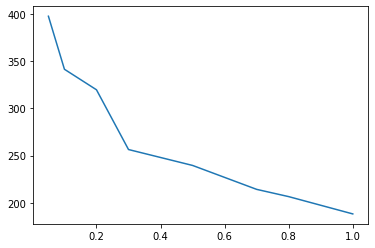

In [23]:
#vae.save("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_5")
print(Track_val_loss)
plt.plot(data_fraction, Track_val_loss)

In [ ]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")

Log loss is:  534.877585849855


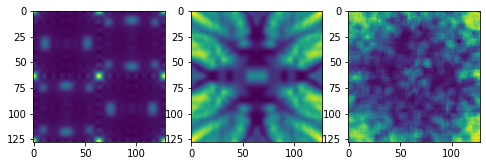

Log loss is:  521.025547153322


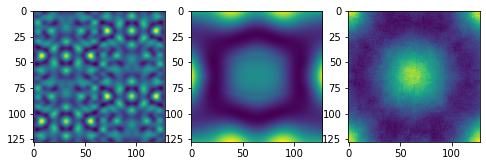

Log loss is:  747.3982674377354


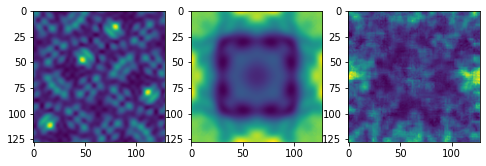

Log loss is:  621.051875482046


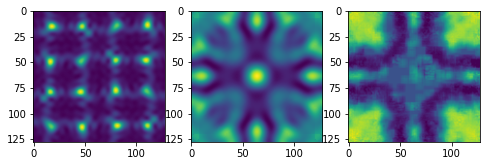

Log loss is:  708.4454852916164


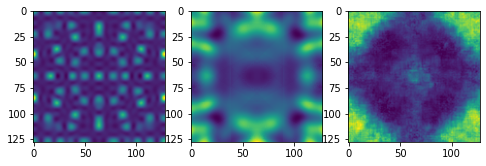

Log loss is:  798.7617333256517


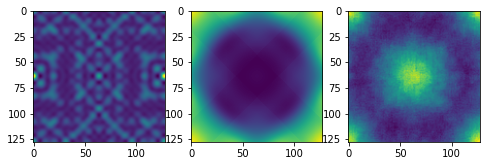

Log loss is:  542.2163192989948


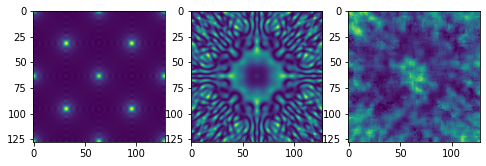

Log loss is:  624.759145213994


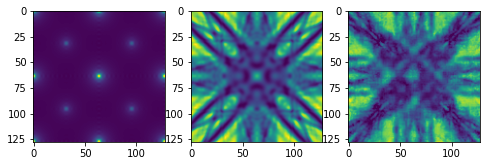

Log loss is:  672.2266277026536


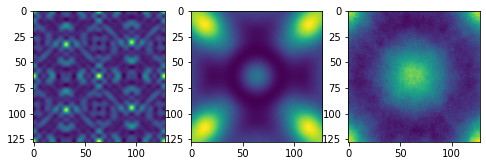

Log loss is:  586.3071310893774


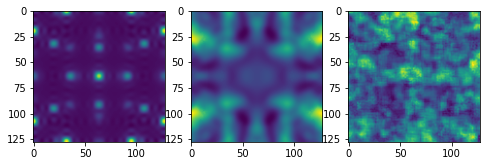

Log loss is:  872.8369027801193


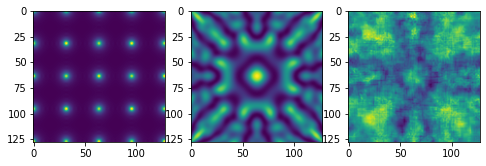

Log loss is:  650.7683754572553


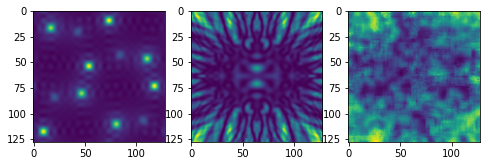

Log loss is:  555.9021536448124


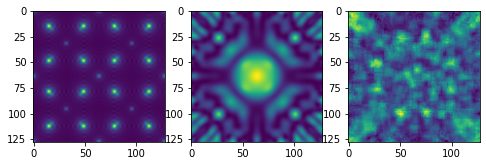

Log loss is:  809.9952528447229


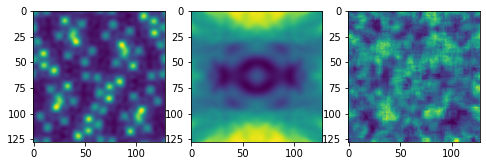

Log loss is:  937.497752775593


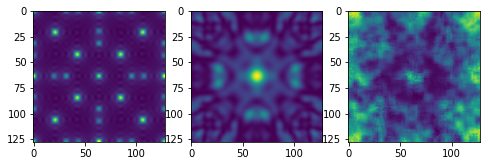

Log loss is:  1275.1549987083977


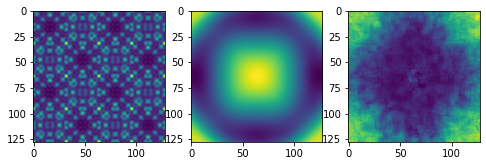

Log loss is:  844.5450801267364


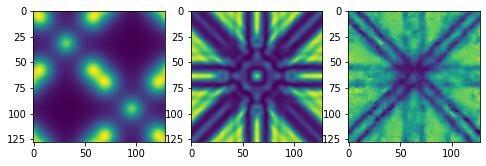

Log loss is:  680.9297818835827


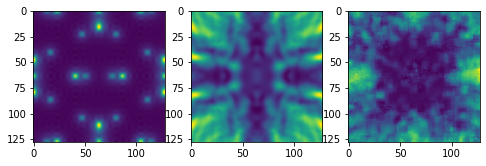

Log loss is:  638.2841789472667


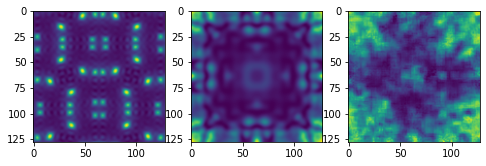

Log loss is:  538.1190453198442


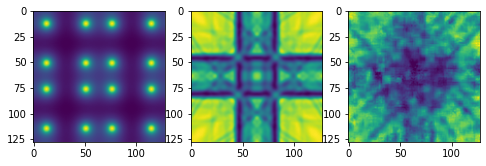

Log loss is:  610.7825134793587


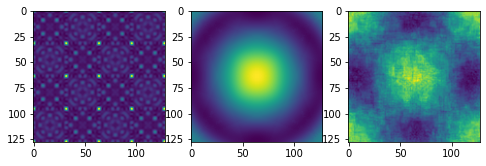

Log loss is:  1359.1365712507484


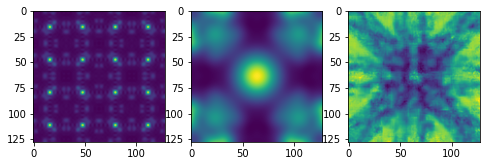

Log loss is:  763.3066894422501


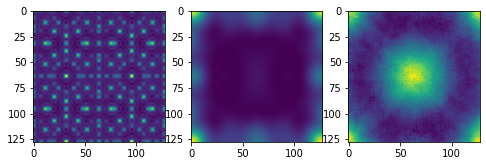

Log loss is:  633.3122069336042


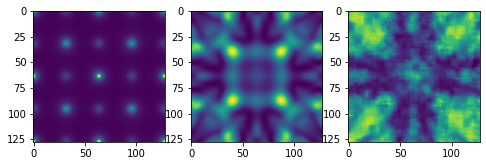

Log loss is:  957.5438608319197


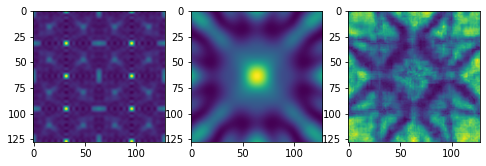

Log loss is:  866.6434782790949


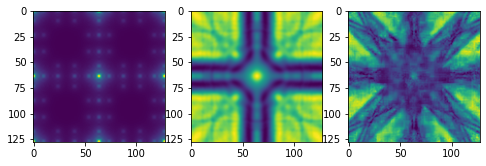

Log loss is:  525.0409851350348


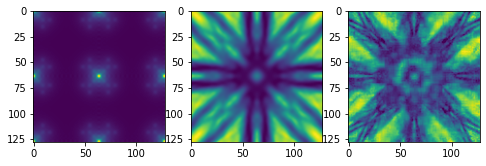

Log loss is:  928.4140308940208


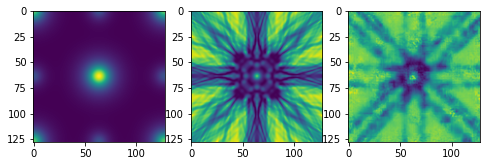

Log loss is:  1014.6684171402394


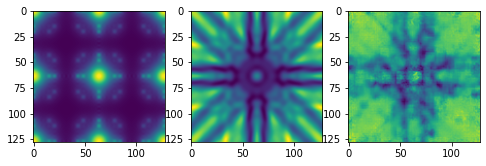

Log loss is:  526.3722911347489


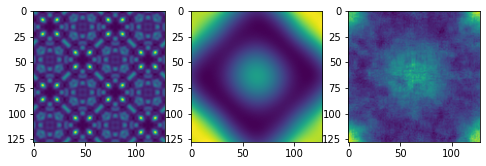

Log loss is:  589.986022641076


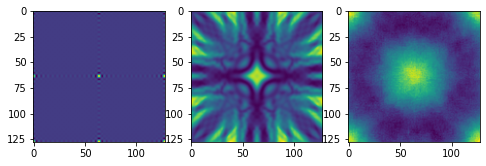

Log loss is:  630.176825830231


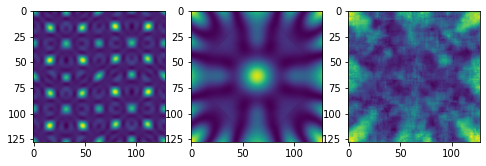

Log loss is:  547.4137211165844


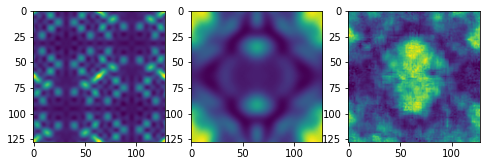

Log loss is:  789.0062353758444


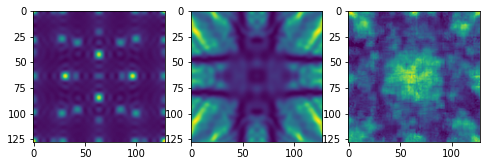

Log loss is:  655.6923783567556


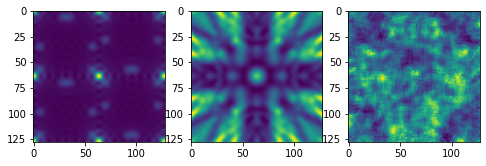

Log loss is:  541.2697498436323


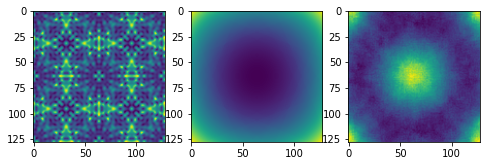

Log loss is:  829.4254670854526


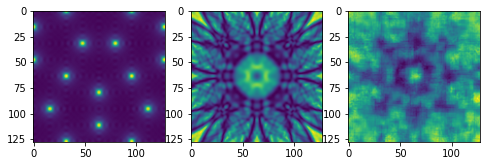

Log loss is:  1266.0333903614492


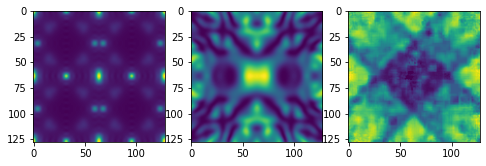

Log loss is:  825.218257814545


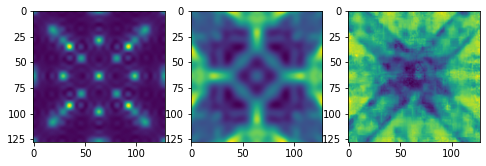

Log loss is:  1884.7567443278888


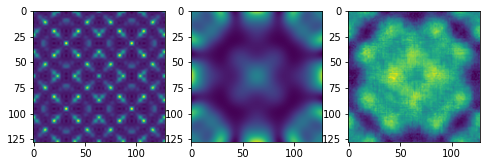

Log loss is:  562.9598104607669


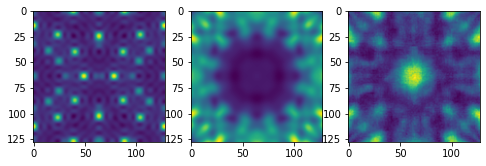

Log loss is:  877.0138500609713


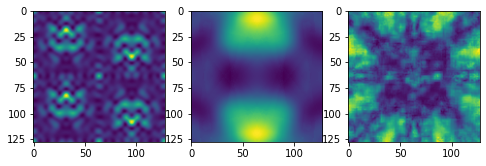

Log loss is:  614.6387292970416


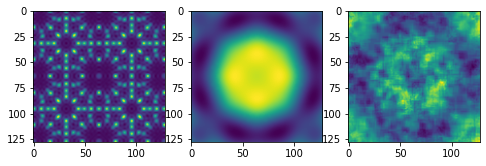

Log loss is:  719.6854008625721


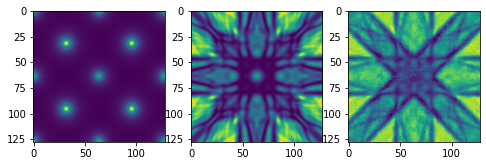

Log loss is:  668.6171160065626


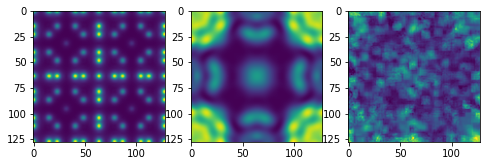

Log loss is:  603.4284182194168


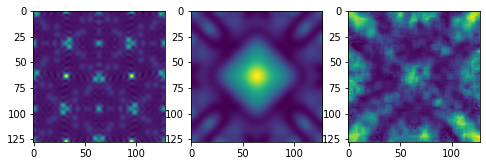

Average loss:  17475.823201257695


In [24]:
average_loss = 0
#data[0][0], data[0][1]
for i in range(0, len(data[0][0])):
    x = np.load(data[0][0][i])
    y = np.load(data[0][1][i])
    #x = np.load(data[0][i])
    #y = np.load(data[1][i])
    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
    #print(TestPaths[0][i])
    log_loss = 0
    for j in range(0, a.shape[0]):
        for k in range(0, a.shape[1]):
            log_loss+=(math.log(1+a[j][k]) - math.log(1+y[j][k])) ** 2
    
    if log_loss > 500:
        print("Log loss is: ", log_loss)
        average_loss+=log_loss
        w=10
        h=10
        fig=plt.figure(figsize=(8, 8))
        columns = 3
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(x)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(y)
        fig.add_subplot(rows, columns, 3)
        plt.imshow(a)
        plt.show()
print("Average loss: ", average_loss / len(data[0]))

In [ ]:
for i in range(0, len(TrainingPaths[0])):
    #x = np.load(data[0][0][i])
    #y = np.load(data[0][1][i])
    x = np.load(TrainingPaths[0][i])
    y = np.load(TrainingPaths[1][i])
    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
    print(TrainingPaths[0][i])

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(y)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(a)
    plt.show()